# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

# Описание целей и задачи проекта

* **Цель данного проекта** заключается в создании приложения для привлечения новых клиентов, для подсчета рыночной стоимости  автомобиля.
* **Задачам проекта** являются:
     + подговить данные к анализу (изменение название столбцов, заполнение пропусков, удаление дубликатов и аномалий в данных) 
     + обучение моделей 
     + анализ моделей 
     + краткий вывод по полученным данным





# Описание данных

Данные записаны в одном csv-файле и представлены в виде **15 фич и 354369 строк.** Некоторые данные повреждены и требуют некоторого внимания. 

# План работы

1. Вывести общую информацию по датафрейму и выяснить: сколько фич имеет датафрейм, количество строк, тип данных.
2. При необходимости изменить название столбцов.
3. Рассмотреть потенциальные пропуски и выяснить - заполнить пропуски или их удалить.
4. Удалить дубликаты.
5. Провести анализ по аномалиям.
6. Разбить данные на обучающую, валидационную и тренировочную выборки.
7. Провести порядковое кодирование.
8. Обучить модели без подбора гиперпараметров.
9. Обучить модели с подбора гиперпараметров.
11. Обучить модели с бустингом.
12. Проверить модели на тренировочной выборке.
13. В выводе отобразить метрику RMSE, время обучения и время предсказания моделей и выявить наилучшую модель.

## Подготовка данных

**Загрузим** необходимые **библиотеки.**

In [1]:
import pandas as pd 
import numpy as np 

**Запишем в переменную csv-файл.**

In [2]:
try:
    data = pd.read_csv('C:/Users/JERR/Desktop/Проекты/Численные методы/autos.csv')
except:
    try:
        data = pd.read_csv('C:/Users/User/Desktop/Проекты/Численные методы/autos.csv')
    except:
        data = pd.read_csv('/datasets/autos.csv')

**Выведем общую информацию** по датафрейму.

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

**Признаки**

* `DateCrawled` — дата скачивания анкеты из базы
* `VehicleType` — тип автомобильного кузова
* `RegistrationYear` — год регистрации автомобиля
* `Gearbox` — тип коробки передач
* `Power` — мощность (л. с.)
* `Model` — модель автомобиля
* `Kilometer` — пробег (км)
* `RegistrationMonth` — месяц регистрации автомобиля
* `FuelType` — тип топлива
* `Brand` — марка автомобиля
* `NotRepaired` — была машина в ремонте или нет
* `DateCreated` — дата создания анкеты
* `NumberOfPictures` — количество фотографий автомобиля
* `PostalCode` — почтовый индекс владельца анкеты (пользователя)
* `LastSeen` — дата последней активности пользователя

**Целевой признак**
* `Price` — цена (евро)

Заметим, что в некоторых столбцах **отсутствует данные.** Так же подчеркнем, что **не все столбцы** представлены **с нормальным типом данных.**

**Переведем названия** столбцов **в нижний регистр.** 

In [4]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [5]:
data.columns = data.columns.str.replace(r"([A-Z])", r" \1").str.lower().str.replace(' ', '_').str[1:]

In [6]:
print(data.columns)

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')


Посчитаем **максимальное количество данных** в столбцах, что посчитать от него **процент потерь.**

In [7]:
max_value_data = data.count().sort_values(ascending=False)[0]
print('Максимальное количество данных в датафрейме:', max_value_data)

Максимальное количество данных в датафрейме: 354369


In [8]:
isna = data.isna().sum().sort_values(ascending=False)
isn = isna.loc[isna != 0]
print(isn)

repaired        71154
vehicle_type    37490
fuel_type       32895
gearbox         19833
model           19705
dtype: int64


**Процент отсутствующих данных.**

In [9]:
difference_value_data = (100 - (data.count() / max_value_data).round(2) * 100).sort_values(ascending=False)
difference_value_data = difference_value_data.loc[difference_value_data != 0]
#difference_value_data = difference_value_data.astype('int')
difference_value_data = difference_value_data.astype('str')
difference_value_data += "%"
print(difference_value_data)

repaired        20.0%
vehicle_type    11.0%
fuel_type        9.0%
gearbox          6.0%
model            6.0%
dtype: object


**Данные отсутствуют** в пяти столбцах. 

In [10]:
pd.DataFrame({'Столбцы': ['repaired', 
                          'vehicletype', 
                          'fueltype', 
                          'gearbox', 
                          'model'],
              'Описание': ['была машина в ремонте или нет', 
                           'тип автомобильного кузова', 
                           'тип топлива', 
                           'тип коробки передач', 
                           'модель автомобиля'],
              'Количество пропусков, %': [difference_value_data[0],
                                          difference_value_data[1], 
                                          difference_value_data[2], 
                                          difference_value_data[3], 
                                          difference_value_data[4]]})

,Столбцы,Описание,"Количество пропусков, %"
0,repaired,была машина в ремонте или нет,20.0%
1,vehicletype,тип автомобильного кузова,11.0%
2,fueltype,тип топлива,9.0%
3,gearbox,тип коробки передач,6.0%
4,model,модель автомобиля,6.0%


### Проверка на пропуски.

In [11]:
def info_columns(columns):
    display(data[columns].head(5))
    display(data[columns].value_counts())

In [12]:
def loss_percentage(columns):
    print('Процент потерь', 100 - data[columns].count() / max_value_data * 100,'%')

**1. Столбец `repaired`.**

In [13]:
info_columns('repaired')

0    NaN
1    yes
2    NaN
3     no
4     no
Name: repaired, dtype: object

no     247161
yes     36054
Name: repaired, dtype: int64

In [14]:
data['repaired'] = data['repaired'].fillna('unknown')

In [15]:
data['repaired'].value_counts()

no         247161
unknown     71154
yes         36054
Name: repaired, dtype: int64

In [16]:
loss_percentage('repaired')

Процент потерь 0.0 %


**2. Столбцец `vehicle_type`.**

In [17]:
info_columns('vehicle_type')

0      NaN
1    coupe
2      suv
3    small
4    small
Name: vehicle_type, dtype: object

sedan          91457
small          79831
wagon          65166
bus            28775
convertible    20203
coupe          16163
suv            11996
other           3288
Name: vehicle_type, dtype: int64

In [18]:
data['vehicle_type'] = data['vehicle_type'].fillna('other')

In [19]:
data['vehicle_type'].value_counts()

sedan          91457
small          79831
wagon          65166
other          40778
bus            28775
convertible    20203
coupe          16163
suv            11996
Name: vehicle_type, dtype: int64

In [20]:
loss_percentage('vehicle_type')

Процент потерь 0.0 %


**3. Столбец `fuel_type`.**

In [21]:
info_columns('fuel_type')

0      petrol
1    gasoline
2    gasoline
3      petrol
4    gasoline
Name: fuel_type, dtype: object

petrol      216352
gasoline     98720
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: fuel_type, dtype: int64

In [22]:
data['fuel_type'] = data['fuel_type'].fillna('other')

In [23]:
data['fuel_type'].value_counts()

petrol      216352
gasoline     98720
other        33099
lpg           5310
cng            565
hybrid         233
electric        90
Name: fuel_type, dtype: int64

In [24]:
loss_percentage('fuel_type')

Процент потерь 0.0 %


**4. Столбец `gearbox`.**

In [25]:
info_columns('gearbox')

0    manual
1    manual
2      auto
3    manual
4    manual
Name: gearbox, dtype: object

manual    268251
auto       66285
Name: gearbox, dtype: int64

In [26]:
data['gearbox'] = data['gearbox'].fillna('unknown')

In [27]:
data['gearbox'].value_counts()

manual     268251
auto        66285
unknown     19833
Name: gearbox, dtype: int64

In [28]:
loss_percentage('gearbox')

Процент потерь 0.0 %


**5. Столбец `model`.**

In [29]:
info_columns('model')

0     golf
1      NaN
2    grand
3     golf
4    fabia
Name: model, dtype: object

golf                  29232
other                 24421
3er                   19761
polo                  13066
corsa                 12570
                      ...  
i3                        8
serie_3                   4
rangerover                4
range_rover_evoque        2
serie_1                   2
Name: model, Length: 250, dtype: int64

In [30]:
data['model'] = data['model'].fillna('other')

In [31]:
data['model'].value_counts()

other                 44126
golf                  29232
3er                   19761
polo                  13066
corsa                 12570
                      ...  
i3                        8
serie_3                   4
rangerover                4
range_rover_evoque        2
serie_1                   2
Name: model, Length: 250, dtype: int64

In [32]:
loss_percentage('model')

Процент потерь 0.0 %


**Вывод общей информации.**

In [33]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354369 non-null  object
 1   price               354369 non-null  int64 
 2   vehicle_type        354369 non-null  object
 3   registration_year   354369 non-null  int64 
 4   gearbox             354369 non-null  object
 5   power               354369 non-null  int64 
 6   model               354369 non-null  object
 7   kilometer           354369 non-null  int64 
 8   registration_month  354369 non-null  int64 
 9   fuel_type           354369 non-null  object
 10  brand               354369 non-null  object
 11  repaired            354369 non-null  object
 12  date_created        354369 non-null  object
 13  number_of_pictures  354369 non-null  int64 
 14  postal_code         354369 non-null  int64 
 15  last_seen           354369 non-null  object
dtypes:

**Изменяем тип данных.**

In [34]:
data['date_crawled'] = pd.to_datetime(data['date_crawled'],  format='%Y-%m-%d %H:%M:%S')
data['date_created'] = pd.to_datetime(data['date_created'],  format='%Y-%m-%d %H:%M:%S')
data['last_seen'] = pd.to_datetime(data['last_seen'],  format='%Y-%m-%d %H:%M:%S')

In [35]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        354369 non-null  datetime64[ns]
 1   price               354369 non-null  int64         
 2   vehicle_type        354369 non-null  object        
 3   registration_year   354369 non-null  int64         
 4   gearbox             354369 non-null  object        
 5   power               354369 non-null  int64         
 6   model               354369 non-null  object        
 7   kilometer           354369 non-null  int64         
 8   registration_month  354369 non-null  int64         
 9   fuel_type           354369 non-null  object        
 10  brand               354369 non-null  object        
 11  repaired            354369 non-null  object        
 12  date_created        354369 non-null  datetime64[ns]
 13  number_of_pictures  354369 no

### Проверка на дубликаты.

In [36]:
print('Количество дубликатов:', data.duplicated().sum())

Количество дубликатов: 4


In [37]:
data = data.drop_duplicates()

In [38]:
print('Количество дубликатов:', data.duplicated().sum())

Количество дубликатов: 0


### Проверка на аномалии.

Рассмотрим минимальный год и максимальный. 

**1. Столбец `registration_year`.**

In [39]:
print('Максимальный год:', data['registration_year'].max())
print('Количество аномальных значений равных 9999 лет:', 
      data['registration_year'].loc[data['registration_year'] == 9999].count())
print('Минимальный год:', data['registration_year'].min())
print('Количество аномальных значений равных 1000 лет:', 
      data['registration_year'].loc[data['registration_year'] == 1000].count())

Максимальный год: 9999
Количество аномальных значений равных 9999 лет: 26
Минимальный год: 1000
Количество аномальных значений равных 1000 лет: 37


In [40]:
data['registration_year'] = data['registration_year'].loc[(data['registration_year'] >= 1885) & 
                                                          (data['registration_year'] <= 2016)]


In [41]:
print('Максимальный год:', data['registration_year'].max())
print('Минимальный год:', data['registration_year'].min())

Максимальный год: 2016.0
Минимальный год: 1910.0


**2. Столбец `power`.**

In [42]:
print('Максимальное значение:', data['power'].max())
print('Минимальное значение:', data['power'].min())

Максимальное значение: 20000
Минимальное значение: 0


In [43]:
data['power'] = data['power'].loc[(data['power'] >= 30) & 
                                  (data['power'] <= 600)]

In [44]:
print('Максимальное значение:', data['power'].max())
print('Минимальное значение:', data['power'].min())

Максимальное значение: 600.0
Минимальное значение: 30.0


**3. Столбец `price`.**

In [45]:
print('Максимальная цена:', data['price'].max())
print('Минимальная цена:', data['price'].min())

Максимальная цена: 20000
Минимальная цена: 0


In [46]:
data['price'] = data['price'].loc[(data['price'] >= 100)]

### Заполнение пропусков после аномалий

**Заполним пропуски** медианым значением.

In [47]:
data['registration_year'] = data['registration_year'].fillna(data['registration_year'].median())
data['power'] = data['power'].fillna(data['power'].median())
data['price'] = data['price'].fillna(data['price'].median())

In [48]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354365 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        354365 non-null  datetime64[ns]
 1   price               354365 non-null  float64       
 2   vehicle_type        354365 non-null  object        
 3   registration_year   354365 non-null  float64       
 4   gearbox             354365 non-null  object        
 5   power               354365 non-null  float64       
 6   model               354365 non-null  object        
 7   kilometer           354365 non-null  int64         
 8   registration_month  354365 non-null  int64         
 9   fuel_type           354365 non-null  object        
 10  brand               354365 non-null  object        
 11  repaired            354365 non-null  object        
 12  date_created        354365 non-null  datetime64[ns]
 13  number_of_pictures  354365 no

### Вывод

Данные подготовлены. Пропуски и дубликаты отсутствуют.

## Обучение моделей

**Подготовим данные.**

In [49]:
data = data.drop(['date_crawled', 
                  'date_created', 
                  'last_seen', 
                  'number_of_pictures', 
                  'postal_code', 
                  'registration_month'], axis=1)

**Разобьем данные** на обучающую, валидационную и тестовую выборки **в отношении 3:1:1.**

In [50]:
from sklearn.model_selection import train_test_split

In [51]:
train, valid_test = train_test_split(data, test_size = .4, random_state=50)
valid, test = train_test_split(valid_test, test_size = .5, random_state=50)

In [52]:
print('Размер обучающей выборки', train.shape, '   от общего',(train.shape[0] / data.shape[0]) * 100,'%')
print('Размер валидационной выборки', valid.shape, 'от общего',(valid.shape[0] / data.shape[0]) * 100,'%')
print('Размер тренировочной выборки', test.shape, 'от общего',(test.shape[0] / data.shape[0]) * 100,'%')

Размер обучающей выборки (212619, 10)    от общего 60.0 %
Размер валидационной выборки (70873, 10) от общего 20.0 %
Размер тренировочной выборки (70873, 10) от общего 20.0 %


In [53]:
X_train = train.drop(['price'], axis=1)
y_train = train['price']

X_valid = valid.drop(['price'], axis=1)
y_valid = valid['price']

X_test = test.drop(['price'], axis=1)
y_test = test['price']

**Применим порядковое кодирование.**

P.S. Прямое кодирование сильно раздует данные.

In [54]:
from sklearn.preprocessing import OrdinalEncoder

In [55]:
encoder = OrdinalEncoder()
X_train = pd.DataFrame(encoder.fit_transform(X_train), columns=X_train.columns) 
X_valid = pd.DataFrame(encoder.fit_transform(X_valid), columns=X_valid.columns) 
X_test = pd.DataFrame(encoder.fit_transform(X_test), columns=X_test.columns)

### Без бустинга.

#### Обучение моделей без подбора гиперпараметров.

In [56]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error
import time

**Линейная регрессия.**

In [57]:
start_time_linear = time.time()

model_linear = LinearRegression()
model_linear.fit(X_train, y_train)

time_linear_training = round(time.time() - start_time_linear, 2)
print(f'Время обучения линейной регрессии: {time_linear_training} сек.')

Время обучения линейной регрессии: 0.08 сек.


In [58]:
start_time_linear = time.time()

predict_linear = model_linear.predict(X_valid)
rmse_linear = mean_absolute_error(predict_linear, y_valid)

time_linear_prediction = round(time.time() - start_time_linear, 2)
print(f'Время предсказания линейной регрессии: {time_linear_prediction} сек.')

Время предсказания линейной регрессии: 0.01 сек.


In [59]:
print('RMSE линейной регрессии:', rmse_linear)

RMSE линейной регрессии: 2571.793981968411


**Дерево решений.**

In [60]:
start_time_tree = time.time()

model_tree = DecisionTreeRegressor()
model_tree.fit(X_train, y_train)

time_tree_training = round(time.time() - start_time_tree, 2)
print(f'Время обучения дерева решений: {time_tree_training} сек.')

Время обучения дерева решений: 0.96 сек.


In [61]:
start_time_tree = time.time()

predict_tree = model_tree.predict(X_valid)
rmse_tree = mean_absolute_error(predict_tree, y_valid)

time_tree_prediction = round(time.time() - start_time_tree, 2)
print(f'Время предсказания дерева решений: {time_tree_prediction} сек.')

Время предсказания дерева решений: 0.04 сек.


In [62]:
print('RMSE дерева решений:', rmse_tree)

RMSE дерева решений: 3505.1700383501907


**Случайный лес.**

In [63]:
start_time_forest = time.time()

model_forest = RandomForestRegressor()
model_forest.fit(X_train, y_train)

time_forest_training = round(time.time() - start_time_forest, 2)
print(f'Время обучения случайного леса: {time_forest_training} сек.')

Время обучения случайного леса: 70.15 сек.


In [64]:
start_time_forest = time.time()

predict_forest = model_forest.predict(X_valid)
rmse_forest = mean_absolute_error(predict_forest, y_valid)

time_forest_prediction = round(time.time() - start_time_forest, 2)
print(f'Время предсказания случайного леса: {time_forest_prediction} сек.')

Время предсказания случайного леса: 2.74 сек.


In [65]:
print('RMSE случайного леса:', rmse_forest)

RMSE случайного леса: 3015.7055013276135


**Дамми регрессия.**

In [66]:
start_time_dummy = time.time()

model_dummy = DummyRegressor()
model_dummy.fit(X_train, y_train)

time_dummy_training = round(time.time() - start_time_dummy, 2)
print(f'Время обучения дамми регрессии: {time_dummy_training} сек.')

Время обучения дамми регрессии: 0.0 сек.


In [67]:
start_time_dummy = time.time()

predict_dummy = model_dummy.predict(X_valid)
rmse_dummy = mean_absolute_error(predict_dummy, y_valid)

time_dummy_prediction = round(time.time() - start_time_dummy, 2)
print(f'Время предсказания дамми регрессии: {time_dummy_prediction} сек.')

Время предсказания дамми регрессии: 0.0 сек.


In [68]:
print('RMSE дамми регрессии:', rmse_dummy)

RMSE дамми регрессии: 3440.1283435249106


In [69]:
model_no_hyperparameters = pd.DataFrame({'Линейная регрессия' : [rmse_linear],
                                            'Дерево решений' : [rmse_tree],
                                            'Случайный лес' : [rmse_forest],
                                            'Дамми регрессия' : [rmse_dummy]}).T


model_no_hyperparameters.columns = ['RMSE']
model_no_hyperparameters = model_no_hyperparameters.sort_values('RMSE', ascending=True)
display(model_no_hyperparameters)

,RMSE
Линейная регрессия,2571.793982
Случайный лес,3015.705501
Дамми регрессия,3440.128344
Дерево решений,3505.170038


#### Обучение моделей c подбором гиперпараметров.

In [70]:
best_model_tree = None
best_model_forest = None

best_result_tree = 5000
best_result_forest = 5000

**Дерево решений с подбором гиперпараметров.**

In [71]:
time_tree_g_training, time_tree_g_prediction = 0, 0


for depth in range(1, 30, 2):
    #-----------------------Обучение модели------------------------------------------------#
    start_time_tree_g = time.time()
    model_tree_g = DecisionTreeRegressor(max_depth=depth)
    model_tree_g.fit(X_train, y_train)
    time_tree_g_training += round(time.time() - start_time_tree_g, 2)
    #-----------------------Предсказание модели--------------------------------------------#
    start_time_tree_g = time.time()
    predict_tree_g = model_tree_g.predict(X_valid)
    rmse_tree_g = mean_absolute_error(predict_tree_g, y_valid)
    time_tree_g_prediction += round(time.time() - start_time_tree_g, 2)
    #-----------------------Выбор лучшей модели--------------------------------------------#
    if best_result_tree > rmse_tree_g:
        best_result_tree = rmse_tree_g
        best_model_tree = model_tree_g

print(f'Время обучения дерева решений: {time_tree_g_training} сек.')
print(f'Время предсказания дерева решений: {time_tree_g_prediction} сек.')

Время обучения дерева решений: 9.209999999999999 сек.
Время предсказания дерева решений: 0.20999999999999996 сек.


In [72]:
print('Лучшая модель:', best_model_tree)
print('RMSE дерева решений:', best_result_tree)

Лучшая модель: DecisionTreeRegressor(max_depth=3)
RMSE дерева решений: 2916.192462338322


**Случайный лес с подбором гиперпараметров.**

In [73]:
time_forest_g_training, time_forest_g_prediction = 0, 0

for est in range(12, 18, 2):
    for depth in range(1, 15, 2):
        #-----------------------Обучение модели------------------------------------------------#
        start_time_forest_g = time.time()
        model_forest_g = RandomForestRegressor(n_estimators=est, max_depth=depth)
        model_forest_g.fit(X_train, y_train)
        time_forest_g_training += round(time.time() - start_time_forest_g, 2)
        #-----------------------Предсказание модели--------------------------------------------#
        start_time_forest_g = time.time()
        predict_forest_g = model_forest_g.predict(X_valid)
        rmse_forest_g = mean_absolute_error(predict_forest_g, y_valid)
        time_forest_g_prediction += round(time.time() - start_time_forest_g, 2)
        #-----------------------Выбор лучшей модели--------------------------------------------#
        if best_result_forest > rmse_forest_g:
            best_result_forest = rmse_forest_g
            best_model_forest = model_forest_g


print(f'Время обучения случайного леса: {time_forest_g_training} сек.')
print(f'Время предсказания случайного леса: {time_forest_g_prediction} сек.')

Время обучения случайного леса: 68.49 сек.
Время предсказания случайного леса: 1.1700000000000002 сек.


In [74]:
print('Лучшая модель:', best_model_forest)
print('RMSE случайного леса:', best_result_forest)

Лучшая модель: RandomForestRegressor(max_depth=3, n_estimators=12)
RMSE случайного леса: 2910.653900780293


Отобразим полученные данные.

In [75]:
model_yes_hyperparameters = pd.DataFrame({'Линейная регрессия' : '-',
                                            'Дерево решений' : [best_result_tree],
                                            'Случайный лес' : [best_result_forest],
                                            'Дамми регрессия' : '-'}).T


model_yes_hyperparameters.columns = ['RMSE']
display(model_yes_hyperparameters)

,RMSE
Линейная регрессия,-
Дерево решений,2916.192462
Случайный лес,2910.653901
Дамми регрессия,-


#### Вывод

In [76]:
model_hyperparameters = pd.DataFrame({'Линейная регрессия' : [rmse_linear, '-'],
                                            'Дерево решений' : [rmse_tree, best_result_tree],
                                            'Случайный лес' : [rmse_forest, best_result_forest],
                                            'Дамми регрессия' : [rmse_dummy, '-']}).T


model_hyperparameters.columns = ['Без подбора (RMSE)', 'С подбором (RMSE)']
display(model_hyperparameters)

,Без подбора (RMSE),С подбором (RMSE)
Линейная регрессия,2571.793982,-
Дерево решений,3505.170038,2916.192462
Случайный лес,3015.705501,2910.653901
Дамми регрессия,3440.128344,-


### Модели с бустингом.

In [77]:
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from lightgbm import plot_importance
from sklearn.datasets import load_boston
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

Training until validation scores don't improve for 50 rounds
[100]	training's l2: 3.15514e+06	valid_1's l2: 9.79621e+06
Did not meet early stopping. Best iteration is:
[100]	training's l2: 3.15514e+06	valid_1's l2: 9.79621e+06
MSE 9796207.11


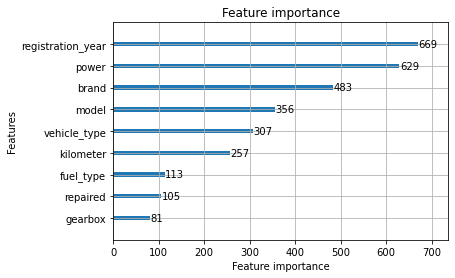

In [78]:
model = LGBMRegressor(
    boosting_type='gbdt',
    num_leaves=31,
    max_depth=-1,
    learning_rate=0.1,
    n_estimators=100,
    objective='regression', # The default is two categories
    min_split_gain=0.0,
    min_child_samples=20,
    subsample=1.0,
    subsample_freq=0,
    colsample_bytree=1.0,
    reg_alpha=0.0,
    reg_lambda=0.0,
    random_state=None,
    silent=True
)

model.fit(X_train,y_train, eval_set=[(X_train, y_train), (X_test, y_test)], 
          verbose=100, early_stopping_rounds=50)

y_pred = model.predict(X_test)
mse = round(mean_squared_error(y_test, y_pred), 2)
print('MSE', mse)

plot_importance(model)
plt.show()

**Бустинг для категориальных признаков.**

In [79]:
cat = CatBoostRegressor(iterations=1000, loss_function = 'RMSE')

#-----------------------Обучение модели------------------------------------------------#

start_time_cat_t = time.time()
cat.fit(X_train, y_train, verbose=100, plot=True)
time_cat_training = round(time.time() - start_time_cat_t, 2)

#-----------------------Предсказание модели--------------------------------------------#

start_time_cat_p = time.time()
predict_cat = cat.predict(X_valid)
time_cat_prediction = round(time.time() - start_time_cat_p, 2)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.095486
0:	learn: 4187.6677082	total: 75ms	remaining: 1m 14s
100:	learn: 1915.0357615	total: 2.37s	remaining: 21.1s
200:	learn: 1828.3429319	total: 4.62s	remaining: 18.4s
300:	learn: 1780.6431658	total: 6.8s	remaining: 15.8s
400:	learn: 1748.5231747	total: 8.93s	remaining: 13.3s
500:	learn: 1724.1255648	total: 11.1s	remaining: 11s
600:	learn: 1703.6491098	total: 13.4s	remaining: 8.9s
700:	learn: 1686.9735718	total: 15.5s	remaining: 6.6s
800:	learn: 1672.0016880	total: 17.6s	remaining: 4.37s
900:	learn: 1659.2654311	total: 19.6s	remaining: 2.16s
999:	learn: 1647.8016574	total: 21.6s	remaining: 0us


In [80]:
print(f'Время обучения Кэтбуста: {time_cat_training} сек.')
print(f'Время предсказания Кэтбуста: {time_cat_prediction} сек.')

Время обучения Кэтбуста: 21.98 сек.
Время предсказания Кэтбуста: 0.03 сек.


In [81]:
rmse_cat = round(mean_absolute_error(y_valid, predict_cat), 2)
print('RMSE Кэтбуста:', rmse_cat)

RMSE Кэтбуста: 2852.2476232088056


## Анализ моделей

**Проанализируем время обучения, время предсказания и качество моделей.**

**Отобразим** полученные **данные.**

In [82]:
model_quality = pd.DataFrame({'Линейная регрессия' : [rmse_linear],
                              'Дерево решений' :     [best_result_tree],
                              'Случайный лес' :      [best_result_forest],
                              'Дамми регрессия' :    [rmse_dummy],
                              'Экс. гр. бустинг' :   ['-'],
                              'Легкий. гр. бустинг' :['-'],
                              'Кэтбуст' :            [rmse_cat]}).T


model_quality.columns = ['Лучшая метрика (RMSE)']

model_training_time = pd.DataFrame({'Линейная регрессия' : [time_linear_training, 
                                                            time_linear_prediction,
                                                            time_linear_training + time_linear_prediction],
                                    'Дерево решений' :     [time_tree_g_training, 
                                                            time_tree_g_prediction,
                                                            time_tree_g_training + time_tree_g_prediction],
                                    'Случайный лес' :      [time_forest_g_training, 
                                                            time_forest_g_prediction,
                                                            time_forest_g_training + time_forest_g_prediction],
                                    'Дамми регрессия' :    [time_dummy_training,
                                                            time_dummy_prediction,
                                                            time_dummy_training + time_dummy_prediction],
                                    'Экс. гр. бустинг' :   ['-', '-', '-'],
                                    'Легкий. гр. бустинг' :['-', '-', '-'],
                                    'Кэтбуст' :            [time_cat_training,
                                                            time_cat_prediction,
                                                            time_cat_training + time_cat_prediction]}).T


model_training_time.columns = ['Время обучения моделей', 'Время предсказания моделей', 'Общее затраченное время']

srd_model = model_quality.join(model_training_time)
display(srd_model)

,Лучшая метрика (RMSE),Время обучения моделей,Время предсказания моделей,Общее затраченное время
Линейная регрессия,2571.793982,0.08,0.01,0.09
Дерево решений,2916.192462,9.21,0.21,9.42
Случайный лес,2910.653901,68.49,1.17,69.66
Дамми регрессия,3440.128344,0.0,0.0,0.0
Экс. гр. бустинг,-,-,-,-
Легкий. гр. бустинг,-,-,-,-
Кэтбуст,2852.247623,21.98,0.03,22.01


Заметим, что четыре модели (линейная регрессия, дерево решений, случайный лес и дамми регрессия) не преодолели метрику RMSE равную 2500, поэтому не могут учавствовать в исследовании. Поэтому остаются три модели с градиентным бустингом. Лучшая из этих моделей Кэтбуст по полученной метрике, времени обучению и предсказания. Последний этап протестировать лучшую модель.

**Тестирование наилучшей модели.**

In [84]:
predict_cat_t = cat.predict(X_test)
rmse_cat_t = round(mean_absolute_error(y_test, predict_cat_t), 2)
print('RMSE Кэтбуста:', rmse_cat_t)

RMSE Кэтбуста: 2109.52


## Общий вывод 

В данном проекте осуществлена **подготовка данных** (исследование на аномании, проверка на дубликаты, преобразование столбцов, заполнение пропущенных значений), **обучение модели без/с подбором гиперпараметров**, **обучены модели с градиентным бустингом**, **произведен анализ моделей** (качество метрики, время обучения и предсказания моделей) и **выяснена модель с наилучшей метрикой.**
    
    
Дерево решений, линейной регресии и случайный лес не подходят из-за высокого RMSE. Дамми регрессия самая быстрая, но самая не точная. Модель с наилучшей метрикой RMSE является (), и время обучения составляет (), а время предсказания (), что лучше из всех обучаемых моделей.